#Linear Algebra for Data Science: HW3, task 1 (2.5 pts)
#Background extraction via SVD
#<div align="right"> &copy; Markiian Novosad & Rostyslav Hryniv, 2023 </div>

## Completed by:   
*   First team member
*   Second team member

The aim of this task is to use the SVD-based $k$-rank approximation of a given matrix to extract the background of a video sequence of frames

In [2]:
import numpy as np
import cv2
import gdown
from PIL import Image
from IPython.display import HTML
from base64 import b64encode

#gdown.download("https://drive.google.com/file/d/1HpNTozAlQN5EREPs1IL2JmrrNEfrWckA/view?usp=sharing", "video.mp4", quiet=False)

def show_video(video_path, video_width = 600):
  mp4 = open(video_path,'rb').read()
  print(len(mp4))
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

In [3]:
show_video('video.mp4')

1841506


#1. Preparation (0.5 pts)

-  take a short video with a fixed background and relatively small moving part
- extract $N$ equally spaced frames and convert them to greyscale images
- reshape each image into a column vector of size $M\times 1$, with $M:=w\times h$
- form a matrix $A$ of $N$ columns

In [19]:
video_file = "./video.mp4"

# Load the video using OpenCV
cap = cv2.VideoCapture(video_file)

# Get the number of frames and height, width of each frame
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))


N = 5 # select desired number of frames
step_size = num_frames // (N + 1)
frame_indices = [i * step_size for i in range(1, N + 1)] # create equaly distributed frame indices over whole video

# Initialize an array to store the selected frames
frames = np.zeros((N, frame_height, frame_width), dtype=np.float32)

# Loop through the selected frames and store them
for i, index in enumerate(frame_indices):
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    ret, frame = cap.read()

    # convert to GrayScale using cv2 and normalize uint8 to floats [0.0, 1.0]
    frames[i] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

# Release the video capture
cap.release()

# Reshape each frame into a column vector
M = frame_height * frame_width
A = np.reshape(frames, newshape=(N, M))
A.shape



(5, 230400)

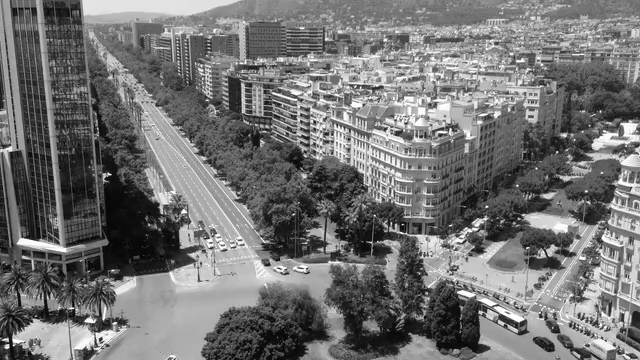

In [20]:
# Visualize any frame from matrix A to make shure that everything is OK with your data
Image.fromarray((np.reshape(A[4], newshape=(frame_height, frame_width)) * 255).astype(np.uint8))


#2. Background extraction (1 pt)

We have the matrix $A$ of $N$ (no. of frames) columns and $M = w \times h$ rows. Our aim here is to find the best rank-$1$ approximation $\mathbf{u}\mathbf{v}^\top$ of $A$

- recall that $\mathbf{v}$ is the eigenvector of an $N\times N$ matrix $A^\top A$ corresponding to the largest eigenvalue; power method should find them very fast
- how do we find $\mathbf{u}$ given $\mathbf{v}$?
---
**_Include your explanations here_**

---
- use $\mathbf{u}\mathbf{v}^\top$ as a background
- remove background from the frames and recombine them into a video with moving part only


In [22]:
A_tA = np.dot(A.T, A)

# Define the number of iterations
num_iterations = 100

# Initialize a random vector v
v = np.random.rand(A.shape[1]).astype(np.float32)

# Normalize the vector v
v = v / np.linalg.norm(v)

# Loop through the iterations
for i in range(num_iterations):
    # Calculate Av
    Av = np.dot(A_tA, v)

    # Normalize Av
    Av = Av / np.linalg.norm(Av)

    # Replace v with Av
    v = Av

# Calculate the largest eigenvalue
lambda_max = np.dot(np.dot(v, A_tA), v)

# Calculate the rank-1 approximation of A
u = np.dot(A, v)
uvt = np.outer(u, v)

# Remove the background from the frames
background = uvt.reshape((A.shape[0], A.shape[1]))
A_foregrounds = np.abs( A - background )
foregrounds = A_foregrounds.reshape((frame_height, frame_width, N)).transpose((2,0,1)) * 255
foregrounds = foregrounds.astype(np.uint8)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 20, (frame_width*2, frame_height))
for i in range(N):
    frame = np.concatenate(...)
    out.write( cv2.cvtColor( frame  , cv2.COLOR_GRAY2BGR) )
out.release()

MemoryError: Unable to allocate 198. GiB for an array with shape (230400, 230400) and data type float32

In [ ]:
show_video("output.mp4")

In case colab doesn't show the video, download it to local storage

In [ ]:
from google.colab import files
files.download("output.mp4")

#3. Rank-$k$ approximation (0.5 pts)


Here, we'll discuss the question whether taking approximation of $A$ of larger rank improves background extraction


- find the best approximation $A_k$ of the matrix $A$ of rank $k$ (can use the built-in SVD function)
- use the columns of $A_k$ as frames of the background
- remove the background from the original frames
- form two videos, with background and moving part
- comment on the results for $k=2, 5, 10$

In [ ]:
rank = ... # choose desired rank
U,s, Vh = np.linalg.svd(A) # Hint: look up svd docs, to make it work more memory efficiently
A_approx = ...

In [ ]:
background = A_approx.reshape(A.shape[0], A.shape[1])
frames_without_background = np.abs(A - background)
foregrounds = frames_without_background.reshape((frame_height, frame_width, N)).transpose((2,0,1)) * 255
foregrounds = foregrounds.astype(np.uint8)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output2.mp4', fourcc, 20, (frame_width*2, frame_height))
for i in range(N):
    frame = np.concatenate(...)
    out.write( cv2.cvtColor( frame  , cv2.COLOR_GRAY2BGR) )
out.release()

#4. Conclusions (0.5 pts)

- Explain why the rank-$1$ approximation of the matrix $A$ typically extracts the background from video
- Discuss whether rank-$k$ approximation improves the process
- Think of advantages, disadvantages, and limitations of the methods
- You can also add some suggestions how this task can be improved in the future

---
**Your comments come here**

---